## Main code for Kaggle - Optiver Realized Volatility Prediction
@LaurentMombaerts 

In [1]:
%reset

## MACHINE TO SET UP

In [2]:
###########################
machine = 'local'
###########################

**Lib Import / Data loading**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob
import time

# Parallel Computing
from joblib import Parallel, delayed

# ML
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import GroupShuffleSplit

# Maths
from scipy.interpolate import interp1d
# from arch import arch_model

# Paths tricks
import os
from pathlib import Path

# Support code
from support_file import *
from information_measures import *

if machine == 'local':
    datapath = os.path.join(str(Path.home()), 'ownCloud', 'Data', 'Kaggle', 'optiver-realized-volatility-prediction')

    # Load dataset
    train = pd.read_csv(os.path.join(datapath,'train.csv')) 
    all_stocks_ids = train['stock_id'].unique()
    all_time_ids = train['time_id'].unique()

    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    train = train[['row_id','target']]

    # Load test ids
    test = pd.read_csv(os.path.join(datapath,'test.csv'))
    all_stocks_ids_test = test['stock_id'].unique()
    test = test.drop(['stock_id','time_id'],axis=1)
    
elif machine == 'kaggle':
    
    # Load dataset
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    all_stocks_ids = train['stock_id'].unique()
    all_time_ids = train['time_id'].unique()

    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    train = train[['row_id','target']]

    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv') 
    all_stocks_ids_test = test['stock_id'].unique()
    test = test.drop(['stock_id','time_id'],axis=1)
    
    datapath = 0
    

**Functions**

In [69]:
def trainModel_timeSplit(X,y,groups,model,splits):
    
    rmspe_list = []
    
    for random_split in range(splits):
        gss = GroupShuffleSplit(n_splits=1, train_size=.80, random_state=random_split)
        gss.get_n_splits()

        for train, test in gss.split(X, y, groups):
            # CV definition
            X_train, X_test = X.iloc[train,:], X.iloc[test,:]
            y_train, y_test = y[train],y[test]
            
            # Add other stocks volatility at same time id and this stock overall volatility
            X_test = get_time_stock(X_test).drop(['row_id','time_id','stock_id'],axis=1)
            X_train = get_time_stock(X_train).drop(['row_id','time_id','stock_id'],axis=1)
    
            # Model definition
            model.fit(X_train,y_train)
            yhat = model.predict(X_test)
    
            # Estimate perf
            rmspe_list.append(rmspe(y_test, yhat))
            
    return rmspe_list

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    
    # df['stock_id'] = [df['row_id'][i].split('-')[0] for i in range(df.shape[0])]
    # df['time_id'] = [df['row_id'][i].split('-')[1] for i in range(df.shape[0])]
            
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 'log_returnMidprice_realized_volatility']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the time id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    
    return df

def train_CatBoost_cv(df_features_train,targets,splits):
    
    model = CatBoostRegressor(verbose=0)

    # Data input / output definition
    X = df_features_train.fillna(0)
    y = targets
    time_id_groups = [df_features_train['row_id'][i].split('-')[1] for i in range(df_features_train.shape[0])]
   
    rmspe_list = trainModel_timeSplit(X,y,time_id_groups,model,splits)
    
    return rmspe_list

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    
    y_true = lgb_train.get_label()
    
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_lgbm_cv(df_features_train,targets,splits):
    
    # Data input / output definition
    X = df_features_train.fillna(0)
    y = targets
    time_id_groups = [df_features_train['time_id'][i] for i in range(df_features_train.shape[0])]

    # Hyperparammeters (just basic)
    params = {
      'objective': 'rmse',  
      'boosting_type': 'gbdt',
      'num_leaves': 100,
      'n_jobs': -1,
      'learning_rate': 0.1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
      'verbose': -1
    }

    rmspe_list = []
    rmspe_list_29 = []
    rmspe_list_37 = []
    rmspe_list_67 = []

    for random_split in range(splits):
        gss = GroupShuffleSplit(n_splits=1, train_size=.80, random_state=random_split)
        gss.get_n_splits()

        for train, test in gss.split(X, y, time_id_groups):
            # CV definition
            x_train, x_val = X.iloc[train,:].reset_index(drop=True), X.iloc[test,:].reset_index(drop=True)
            y_train, y_val = y[train].reset_index(drop=True),y[test].reset_index(drop=True)
            y_val_29 = y_val[x_val['stock_id']==29]
            y_val_37 = y_val[x_val['stock_id']==37]
            y_val_67 = y_val[x_val['stock_id']==67]

            # Add other stocks volatility at same time id and this stock overall volatility
            x_val = get_time_stock(x_val).drop(['time_id'],axis=1)
            x_val['stock_id'] = x_val['stock_id'].astype(int)
            x_train = get_time_stock(x_train).drop(['time_id'],axis=1)
            x_train['stock_id'] = x_train['stock_id'].astype(int)

            # Root mean squared percentage error weights
            train_weights = 1 / np.square(y_train)
            val_weights = 1 / np.square(y_val)
            train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
            val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])

            # Model definition
            model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 10000, 
                          early_stopping_rounds = 50, 
                          verbose_eval = 50,
                          feval = feval_rmspe)

            yhat = model.predict(x_val)
            yhat_29 = model.predict(x_val[x_val['stock_id']==29])
            yhat_37 = model.predict(x_val[x_val['stock_id']==37])
            yhat_67 = model.predict(x_val[x_val['stock_id']==67])

            # Estimate perf
            rmspe_list.append(rmspe(y_val, yhat))
            rmspe_list_29.append(rmspe(y_val_29, yhat_29))
            rmspe_list_37.append(rmspe(y_val_37, yhat_37))
            rmspe_list_67.append(rmspe(y_val_67, yhat_67))
            
    return pd.DataFrame(list(zip(rmspe_list, rmspe_list_29, rmspe_list_37, rmspe_list_67)), columns=['rmspe', 'rmspe29', 'rmspe37', 'rmspe67'])

def train_lgbm(df_features_train,targets):
    
    # Data input / output definition
    X = df_features_train.fillna(0)
    X['stock_id'] = X['stock_id'].astype(int)
    y = targets

    # Hyperparammeters (just basic)
    params = {
      'objective': 'rmse',  
      'boosting_type': 'gbdt',
      'num_leaves': 100,
      'n_jobs': -1,
      'learning_rate': 0.1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.8,
      'verbose': -1
    }

    X['stock_id'] = X['stock_id'].astype(int)
            
    # Root mean squared percentage error weights
    train_weights = 1 / np.square(y)
    train_dataset = lgb.Dataset(X, y, weight = train_weights, categorical_feature = ['stock_id'])

    # Model definition
    model = lgb.train(params = params, 
                  train_set = train_dataset, 
                  num_boost_round = 50, 
                  verbose_eval = 50,
                  feval = feval_rmspe)
            
    return model

In [5]:
# Competition metric
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

# Prediction function (chose here which prediction strategy to use)
def prediction_function(pred, machine, targets, all_stocks_ids, datapath, test, all_stocks_ids_test):
        
    if pred == 'entropy':
        if machine == 'local':
            # Load data
            df_features_encoded_test = computeFeatures_wEntropy(machine=machine, dataset='test', all_stocks_ids=all_stocks_ids, datapath=datapath)
            df_features_encoded_train = computeFeatures_wEntropy(machine=machine, dataset='train', all_stocks_ids=all_stocks_ids, datapath=datapath)
            X = df_features_encoded_train.drop(['row_id'],axis=1)
            y = targets
            
            # Model
            model = CatBoostRegressor(verbose=0)
            model.fit(X,y)
            
            # Predicting targets from same
            yhat = model.predict(X)
            
            print('New model catboost perf : ', rmspe(y, yhat))
            
            # Submission file
            yhat_pd = pd.DataFrame(yhat,columns=['target'])
            return pd.concat([df_features_encoded_train['row_id'],yhat_pd],axis=1)

        # Features computation
        df_features_encoded_test = computeFeatures_wEntropy(machine=machine, dataset='test', all_stocks_ids=all_stocks_ids, datapath=datapath)
        df_features_encoded_train = computeFeatures_wEntropy(machine=machine, dataset='train', all_stocks_ids=all_stocks_ids, datapath=datapath)
        
        # Training model
        X = df_features_encoded_train.drop(['row_id'],axis=1)
        y = targets
        
        # Optimized model
        model = CatBoostRegressor(verbose=0)
        model.fit(X,y)
        
        # Predicting targets from test
        X_test = df_features_encoded_test.drop(['row_id'],axis=1)
        yhat = model.predict(X_test)
        
        # Submission file
        yhat_pd = pd.DataFrame(yhat,columns=['target'])
        submission_file = pd.concat([df_features_encoded_test['row_id'],yhat_pd],axis=1)
        
    if pred == 'new_test_laurent':
        if machine == 'local':
            # Load data
            df_features_encoded_test = computeFeatures_newTest_Laurent(machine=machine, dataset='test', all_stocks_ids=all_stocks_ids, datapath=datapath)
            df_features_encoded_train = computeFeatures_newTest_Laurent(machine=machine, dataset='train', all_stocks_ids=all_stocks_ids, datapath=datapath)
            X = df_features_encoded_train.drop(['row_id'],axis=1)
            y = targets
            
            # Model
            model = CatBoostRegressor(verbose=0)
            model.fit(X,y)
            
            # Predicting targets from same
            yhat = model.predict(X)
            
            print('New model catboost perf : ', rmspe(y, yhat))
            
            # Submission file
            yhat_pd = pd.DataFrame(yhat,columns=['target'])
            return pd.concat([df_features_encoded_test['row_id'],yhat_pd],axis=1)

        # Features computation
        df_features_encoded_test = computeFeatures_newTest_Laurent(machine=machine, dataset='test', all_stocks_ids=all_stocks_ids, datapath=datapath)
        df_features_encoded_train = computeFeatures_newTest_Laurent(machine=machine, dataset='train', all_stocks_ids=all_stocks_ids, datapath=datapath)
        
        # Training model
        X = df_features_encoded_train.drop(['row_id'],axis=1)
        y = targets
        
        # Optimized model
        model = CatBoostRegressor(verbose=0)
        model.fit(X,y)
        
        # Predicting targets from test
        X_test = df_features_encoded_test.drop(['row_id'],axis=1)
        yhat = model.predict(X_test)
        
        # Submission file
        yhat_pd = pd.DataFrame(yhat,columns=['target'])
        submission_file = pd.concat([df_features_encoded_test['row_id'],yhat_pd],axis=1)
        
    if pred == 'new_test_laurent_withoutEncoding':
        if machine == 'local':
            # Load data
            df_features_encoded_test = computeFeatures_newTest_Laurent_noCode(machine=machine, dataset='test', all_stocks_ids=all_stocks_ids, datapath=datapath)
            df_features_encoded_train = computeFeatures_newTest_Laurent_noCode(machine=machine, dataset='train', all_stocks_ids=all_stocks_ids, datapath=datapath)
            X = df_features_encoded_train.drop(['row_id'],axis=1)
            y = targets
            
            # Model
            model = CatBoostRegressor(verbose=0)
            model.fit(X,y)
            
            # Predicting targets from same
            yhat = model.predict(X)
            
            print('New model catboost perf : ', rmspe(y, yhat))
            
            # Submission file
            yhat_pd = pd.DataFrame(yhat,columns=['target'])
            return pd.concat([df_features_encoded_test['row_id'],yhat_pd],axis=1)

        # Features computation
        df_features_encoded_test = computeFeatures_newTest_Laurent_noCode(machine=machine, dataset='test', all_stocks_ids=all_stocks_ids, datapath=datapath)
        df_features_encoded_train = computeFeatures_newTest_Laurent_noCode(machine=machine, dataset='train', all_stocks_ids=all_stocks_ids, datapath=datapath)
        
        # Training model
        X = df_features_encoded_train.drop(['row_id'],axis=1)
        y = targets
        
        # Optimized model
        model = CatBoostRegressor(verbose=0)
        model.fit(X,y)
        
        # Predicting targets from test
        X_test = df_features_encoded_test.drop(['row_id'],axis=1)
        yhat = model.predict(X_test)
        
        # Submission file
        yhat_pd = pd.DataFrame(yhat,columns=['target'])
        submission_file = pd.concat([df_features_encoded_test['row_id'],yhat_pd],axis=1)
        
    if pred == 'new_test_laurent_withoutEncoding_wTrades':
        if machine == 'local':
            # Load data
            df_features_encoded_test = computeFeatures_newTest_Laurent_wTrades(machine=machine, dataset='test', all_stocks_ids=all_stocks_ids, datapath=datapath)
            df_features_encoded_train = computeFeatures_newTest_Laurent_wTrades(machine=machine, dataset='train', all_stocks_ids=all_stocks_ids, datapath=datapath)
            X = df_features_encoded_train.drop(['row_id'],axis=1)
            y = targets
            
            # Model
            model = CatBoostRegressor(verbose=0)
            model.fit(X,y)
            
            # Predicting targets from same
            yhat = model.predict(X)
            
            print('New model catboost perf : ', rmspe(y, yhat))
            
            # Submission file
            yhat_pd = pd.DataFrame(yhat,columns=['target'])
            return pd.concat([df_features_encoded_test['row_id'],yhat_pd],axis=1)

        # Features computation
        df_features_encoded_test = computeFeatures_newTest_Laurent_wTrades(machine=machine, dataset='test', all_stocks_ids=all_stocks_ids, datapath=datapath)
        df_features_encoded_train = computeFeatures_newTest_Laurent_wTrades(machine=machine, dataset='train', all_stocks_ids=all_stocks_ids, datapath=datapath)
        
        # Training model
        X = df_features_encoded_train.drop(['row_id'],axis=1)
        y = targets
        
        # Optimized model
        model = CatBoostRegressor(verbose=0)
        model.fit(X,y)
        
        # Predicting targets from test
        X_test = df_features_encoded_test.drop(['row_id'],axis=1)
        yhat = model.predict(X_test)
        
        # Submission file
        yhat_pd = pd.DataFrame(yhat,columns=['target'])
        submission_file = pd.concat([df_features_encoded_test['row_id'],yhat_pd],axis=1)
        
        
    if pred == 'garch':
        
        if machine == 'local':
            book_path_train = glob.glob(os.path.join(datapath,'book_train.parquet','*')) 
            
            # fit garch and predict
            prediction = garch_volatility_per_stock(list_file=book_path_train, prediction_column_name='pred')
            
            # Merge and evaluate results
            prediction = train.merge(prediction[['row_id','pred']], on = ['row_id'], how = 'left')
            prediction = prediction[prediction.pred.notnull()]

            # Estimate performances
            R2 = round(r2_score(y_true = prediction['target'], y_pred = prediction['pred']),3)
            RMSPE = round(rmspe(y_true = prediction['target'], y_pred = prediction['pred']),3)

            print('--')
            print(f'Performance of prediction: R2 score: {R2}, RMSPE: {RMSPE}')

            prediction = prediction.drop(columns=['target'])
            prediction = prediction.rename(columns={'pred': 'target'})
            
            return prediction
        

    if pred == 'test_2807':
        if machine == 'local':

            # Load data
            df_features_test = computeFeatures_2807(machine=machine, dataset='test', all_stocks_ids=[0], datapath=datapath).fillna(0)
            df_features_train = computeFeatures_2807(machine=machine, dataset='train', all_stocks_ids=all_stocks_ids, datapath=datapath).fillna(0)

            # saving features to the .csv file
            print('['+time.strftime('%X')+']', 'Saving features to .csv files ...') # print also time
            df_features_train.to_csv('df_features_train.csv')
            df_features_test.to_csv('df_features_test.csv')
                              
            # Modelling
            start = time.time()
            print('['+time.strftime('%X')+']', 'Model Training on splits...')
            
            # Model list
            #list_rmspe = train_CatBoost_cv(df_features_train=df_features_train,targets=targets,splits=10)
            list_rmspe = train_lgbm_cv(df_features_train=df_features_train,targets=targets,splits=10)
            
            print('['+time.strftime('%X')+']', 'Training on splits took ',  time.time() - start, 'seconds')
            
            # Print results
            print(list_rmspe)
            print('Mean of RMSPE : ', np.mean(np.array(list_rmspe)), ' +- ', np.std(np.array(list_rmspe)))
            
            return df_features_train # Returns the feature in local mode for further use

        # Features computation
        df_features_test = computeFeatures_2807(machine=machine, dataset='test', all_stocks_ids=all_stocks_ids_test, datapath=datapath).fillna(0)
        df_features_test = test.merge(df_features_test, on = ['row_id'], how = 'left') # Should ensure order of predictions
        df_features_train = computeFeatures_2807(machine=machine, dataset='train', all_stocks_ids=all_stocks_ids, datapath=datapath).fillna(0)
        rows_id_to_merge = df_features_test['row_id'].copy()
        
        # Add other stocks volatility at same time id and this stock overall volatility
        df_features_test = get_time_stock(df_features_test).drop(['row_id','time_id'],axis=1)
        df_features_test['stock_id'] = df_features_test['stock_id'].astype(int)
        df_features_train = get_time_stock(df_features_train).drop(['row_id','time_id'],axis=1)
        
        # Optimized model
        model = train_lgbm(df_features_train=df_features_train, targets=targets)
        
        # Predicting targets from test
        yhat = model.predict(df_features_test)
        
        # Submission file
        yhat_pd = pd.DataFrame(yhat,columns=['target'])
        submission_file = pd.concat([rows_id_to_merge,yhat_pd],axis=1)    

    if pred == 'naive':
        if machine == 'local':
            df_naive_pred = past_realized_volatility_per_stock(list_file=glob.glob(os.path.join(datapath, 'book_train.parquet','*')), prediction_column_name='prediction')
            df_joined = train.merge(df_naive_pred, on='row_id', how='left')
            print('RMSPE = {rmspe(y_true = df_joined["target"], y_pred = df_joined["prediction"])}')
            
            return df_joined
    submission_file = []


    return submission_file

**Submission**

In [ ]:
# New sub
import warnings
warnings.filterwarnings('ignore')
df_submission = prediction_function(pred='test_2807',machine=machine,targets=train['target'],all_stocks_ids=all_stocks_ids, datapath=datapath, test=test, all_stocks_ids_test=all_stocks_ids_test)
# if machine == 'kaggle':
#     df_submission.to_csv('submission.csv',index=False)
# else:
#     df_submission.iloc[0:10,:].to_csv('features_train_head.csv')

### Try other stuff

In [6]:
# load precomputed features
features_temp = pd.read_csv('df_features_train.csv')
del features_temp['Unnamed: 0']
features_temp['stock_id'] = features_temp['row_id'].apply(lambda x: int(x.split('-')[0]))
features_temp['time_id']  = features_temp['row_id'].apply(lambda x: int(x.split('-')[1]))
del features_temp['row_id']
features_temp.shape

(428932, 37)

In [70]:
# train using lgbm and check performance for all vs stock_id==29
our_method = train_lgbm_cv(features_temp, train['target'], splits=15)
our_method

/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000455949	training's RMSPE: 0.211293	valid_1's rmse: 0.000513567	valid_1's RMSPE: 0.236448
[100]	training's rmse: 0.000421443	training's RMSPE: 0.195302	valid_1's rmse: 0.000513366	valid_1's RMSPE: 0.236355
Early stopping, best iteration is:
[75]	training's rmse: 0.00043607	training's RMSPE: 0.20208	valid_1's rmse: 0.000510599	valid_1's RMSPE: 0.235081


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000455307	training's RMSPE: 0.210638	valid_1's rmse: 0.000492729	valid_1's RMSPE: 0.228402
[100]	training's rmse: 0.000420848	training's RMSPE: 0.194696	valid_1's rmse: 0.000498428	valid_1's RMSPE: 0.231044
Early stopping, best iteration is:
[58]	training's rmse: 0.000448081	training's RMSPE: 0.207296	valid_1's rmse: 0.000492358	valid_1's RMSPE: 0.22823


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000456235	training's RMSPE: 0.210857	valid_1's rmse: 0.000498049	valid_1's RMSPE: 0.231787
Early stopping, best iteration is:
[47]	training's rmse: 0.000459741	training's RMSPE: 0.212477	valid_1's rmse: 0.000497845	valid_1's RMSPE: 0.231692


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000458152	training's RMSPE: 0.210508	valid_1's rmse: 0.000488198	valid_1's RMSPE: 0.232352
[100]	training's rmse: 0.000422583	training's RMSPE: 0.194165	valid_1's rmse: 0.000490523	valid_1's RMSPE: 0.233459
Early stopping, best iteration is:
[58]	training's rmse: 0.00045162	training's RMSPE: 0.207507	valid_1's rmse: 0.00048733	valid_1's RMSPE: 0.231939


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000453385	training's RMSPE: 0.210599	valid_1's rmse: 0.000513246	valid_1's RMSPE: 0.234035
Early stopping, best iteration is:
[46]	training's rmse: 0.000458723	training's RMSPE: 0.213078	valid_1's rmse: 0.000512256	valid_1's RMSPE: 0.233584


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000449014	training's RMSPE: 0.209609	valid_1's rmse: 0.000524824	valid_1's RMSPE: 0.234295
[100]	training's rmse: 0.000416931	training's RMSPE: 0.194632	valid_1's rmse: 0.000531939	valid_1's RMSPE: 0.237471
Early stopping, best iteration is:
[50]	training's rmse: 0.000449014	training's RMSPE: 0.209609	valid_1's rmse: 0.000524824	valid_1's RMSPE: 0.234295


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000453873	training's RMSPE: 0.210067	valid_1's rmse: 0.000495339	valid_1's RMSPE: 0.229212
Early stopping, best iteration is:
[48]	training's rmse: 0.000456097	training's RMSPE: 0.211096	valid_1's rmse: 0.000495244	valid_1's RMSPE: 0.229168


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.00045198	training's RMSPE: 0.209421	valid_1's rmse: 0.000505214	valid_1's RMSPE: 0.232751
Early stopping, best iteration is:
[44]	training's rmse: 0.00045951	training's RMSPE: 0.212909	valid_1's rmse: 0.000503609	valid_1's RMSPE: 0.232011


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000451597	training's RMSPE: 0.20968	valid_1's rmse: 0.000505072	valid_1's RMSPE: 0.230708
Early stopping, best iteration is:
[42]	training's rmse: 0.000460868	training's RMSPE: 0.213985	valid_1's rmse: 0.000503648	valid_1's RMSPE: 0.230058


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000455734	training's RMSPE: 0.210194	valid_1's rmse: 0.000503493	valid_1's RMSPE: 0.236202
[100]	training's rmse: 0.00042066	training's RMSPE: 0.194017	valid_1's rmse: 0.00050535	valid_1's RMSPE: 0.237073
Early stopping, best iteration is:
[54]	training's rmse: 0.00045155	training's RMSPE: 0.208264	valid_1's rmse: 0.00050315	valid_1's RMSPE: 0.236041


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000451483	training's RMSPE: 0.210587	valid_1's rmse: 0.00050705	valid_1's RMSPE: 0.227177
[100]	training's rmse: 0.000417136	training's RMSPE: 0.194566	valid_1's rmse: 0.000508921	valid_1's RMSPE: 0.228015
Early stopping, best iteration is:
[56]	training's rmse: 0.000446897	training's RMSPE: 0.208448	valid_1's rmse: 0.000506419	valid_1's RMSPE: 0.226894


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.00045803	training's RMSPE: 0.210809	valid_1's rmse: 0.000487352	valid_1's RMSPE: 0.230475
[100]	training's rmse: 0.00042288	training's RMSPE: 0.194632	valid_1's rmse: 0.000491665	valid_1's RMSPE: 0.232515
Early stopping, best iteration is:
[54]	training's rmse: 0.000454663	training's RMSPE: 0.20926	valid_1's rmse: 0.000486676	valid_1's RMSPE: 0.230156


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000453145	training's RMSPE: 0.209904	valid_1's rmse: 0.000502564	valid_1's RMSPE: 0.231779
[100]	training's rmse: 0.000420664	training's RMSPE: 0.194859	valid_1's rmse: 0.000504733	valid_1's RMSPE: 0.23278
Early stopping, best iteration is:
[50]	training's rmse: 0.000453145	training's RMSPE: 0.209904	valid_1's rmse: 0.000502564	valid_1's RMSPE: 0.231779


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.000454896	training's RMSPE: 0.210917	valid_1's rmse: 0.000492589	valid_1's RMSPE: 0.226298
[100]	training's rmse: 0.000422503	training's RMSPE: 0.195898	valid_1's rmse: 0.000496464	valid_1's RMSPE: 0.228079
Early stopping, best iteration is:
[51]	training's rmse: 0.000454226	training's RMSPE: 0.210606	valid_1's rmse: 0.000492403	valid_1's RMSPE: 0.226213


/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.00045317	training's RMSPE: 0.210126	valid_1's rmse: 0.000503263	valid_1's RMSPE: 0.231163
[100]	training's rmse: 0.00041781	training's RMSPE: 0.19373	valid_1's rmse: 0.000506792	valid_1's RMSPE: 0.232784
Early stopping, best iteration is:
[57]	training's rmse: 0.000448021	training's RMSPE: 0.207738	valid_1's rmse: 0.000502403	valid_1's RMSPE: 0.230768


,rmspe,rmspe29,rmspe37,rmspe67
0,0.235081,0.192264,0.314236,0.193044
1,0.228230,0.185136,0.297435,0.196694
2,0.231692,0.187764,0.294948,0.189984
3,0.231939,0.202258,0.318249,0.201228
4,0.233584,0.192846,0.285970,0.193566
5,0.234295,0.205883,0.300429,0.197022
6,0.229168,0.202658,0.313060,0.195120
7,0.232011,0.196003,0.348689,0.202368
8,0.230058,0.198156,0.307756,0.195608
9,0.236041,0.182476,0.328170,0.195233


In [71]:
# calculate the mean error across splits
np.mean(our_method) # 15% lower error for stock 29

rmspe      0.231194
rmspe29    0.196192
rmspe37    0.307712
rmspe67    0.196659
dtype: float64

In [10]:
# Run persistence prediction and join with targets to compute RMSPE
test_df = past_realized_volatility_per_stock(list_file=glob.glob(os.path.join(datapath, 'book_train.parquet','*')), prediction_column_name='prediction')
df_joined = train.merge(test_df, on='row_id', how='left')
df_joined['stock_id'] = df_joined['row_id'].apply(lambda x: int(x.split('-')[0]))

# Compute and print RMSPE (31% lower error)
persistence_rmspe = rmspe(df_joined['target'], df_joined['prediction'])
persistence_rmspe_29 = rmspe(df_joined[df_joined['stock_id']==29]['target'], df_joined[df_joined['stock_id']==29]['prediction'])
print([persistence_rmspe, persistence_rmspe_29])

[0.34135449018801606, 0.2327475775825411]


In [73]:
# calculate the rmspe for each stock
rmspe_per_stock = df_joined.groupby('stock_id')[['target', 'prediction']].apply(lambda x: rmspe(x['target'], x['prediction']))
# show the stats for rmspe per stock
rmspe_per_stock.describe()

count    112.000000
mean       0.331071
std        0.083532
min        0.217429
25%        0.293993
50%        0.322695
75%        0.355537
max        1.039011
dtype: float64

In [74]:
# show the rmspe for outlier stocks and compare it to the full sample of stocks
rmspe_per_stock[[29,67]]

stock_id
29    0.232748
67    0.293816
dtype: float64

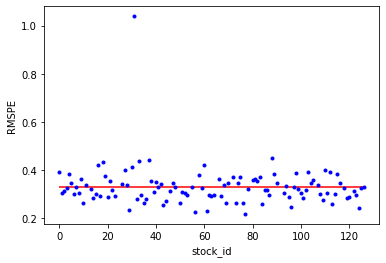

In [97]:
# plot the RMSPE for all stocks with the average line
plt.plot(rmspe_per_stock, 'b.')
plt.hlines(np.mean(rmspe_per_stock), xmin=0, xmax=126, colors='r')
plt.xlabel('stock_id')
plt.ylabel('RMSPE')
plt.show()

## Add clusters to the `features_temp`
### (need to revert changes to the `train_lgbm_cv` before running)

In [29]:
# read files
stock_clusters = pd.read_csv('stock_clusters.csv')
time_clusters = pd.read_csv('time_clusters.csv')
stock_clusters_vol = pd.read_csv('stock_clusters_volatility.csv')

# merge the tables into features_temp
features_temp = pd.merge(features_temp, stock_clusters, on='stock_id', how='left')
features_temp = pd.merge(features_temp, time_clusters, on='time_id', how='left')
features_temp = pd.merge(features_temp, stock_clusters_vol, on='stock_id', how='left')

In [30]:
# normalize the data (only for appropriate columns)
from sklearn import preprocessing

data = features_temp.loc[:, features_temp.columns[0:35]]
scaler = preprocessing.StandardScaler().fit(data)
data_scaled = scaler.transform(data)
features_scaled = pd.concat([pd.DataFrame(data_scaled, columns=data.columns), features_temp.loc[:,features_temp.columns[35:]]], axis=1)
features_scaled

,wap_sum,wap_mean,wap_std,mid_price_sum,mid_price_mean,mid_price_std,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,...,trade_avg_trade_size,stock_id,time_id,km_x,hc_x,ha_x,km_y,hc_y,ha_y,km_v
0,-0.639031,1.104316,-0.396660,-0.639001,1.111899,-0.469451,0.619973,0.074238,0.705678,0.150592,...,-0.469105,0,5,2,1,1,3,1,1,3
1,-1.397873,0.069885,-0.806592,-1.397924,0.060385,-0.803573,0.100188,-0.844596,0.169450,-0.693876,...,-0.542342,0,11,2,1,1,1,1,1,3
2,-1.487201,-0.136938,-0.233761,-1.487174,-0.130757,-0.319051,-0.554959,-0.519973,-1.022713,-0.268272,...,-0.435558,0,16,2,1,1,1,1,1,3
3,-1.988207,-0.347661,-0.336160,-1.988175,-0.336548,-0.444075,-0.757878,-0.462721,-2.193842,0.034539,...,-0.418375,0,31,2,1,1,1,1,1,3
4,-1.575404,-0.114151,-0.810551,-1.575427,-0.119067,-0.848177,0.002744,-0.652162,0.001207,-0.412300,...,-0.571358,0,62,2,1,1,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,-0.589373,-0.124951,-0.593530,-0.589716,-0.170105,-0.588372,-0.138693,-0.151275,-0.155527,-0.088900,...,-0.515109,126,32751,2,1,1,1,1,1,2
428928,-1.224837,0.733630,0.146578,-1.225015,0.704073,0.191491,1.196938,-0.036057,1.848355,0.226598,...,-0.621700,126,32753,2,1,1,1,1,1,2
428929,-0.983920,0.320113,-0.613047,-0.984409,0.244283,-0.598003,0.413562,-0.311090,0.554660,-0.160531,...,-0.361180,126,32758,2,1,1,1,1,1,2
428930,0.072101,0.535701,-0.621808,0.072293,0.556692,-0.640814,0.072112,-0.159511,0.061596,-0.217657,...,-0.338337,126,32763,2,1,1,1,1,1,2


## train the model with these features

In [ ]:
my_list_rmspe = train_lgbm_cv(df_features_train=features_scaled,targets=train['target'],splits=10)
my_list_rmspe1 = train_lgbm_cv(df_features_train=features_temp,targets=train['target'],splits=10)
my_list_rmspe2 = train_lgbm_cv(df_features_train=features_temp.loc[:, features_temp.columns[0:37]],targets=train['target'],splits=10)
my_list_rmspe3 = train_lgbm_cv(df_features_train=features_temp.loc[:, features_temp.columns[np.r_[0:37, 43]]],targets=train['target'],splits=10)

In [51]:
print('Mean of RMSPE (initial = 35) : ', np.mean(np.array(my_list_rmspe2)), u'\u00B1', np.std(np.array(my_list_rmspe2)))
print('Mean of RMSPE (initial + volatility clusters = 36) : ', np.mean(np.array(my_list_rmspe3)), u'\u00B1', np.std(np.array(my_list_rmspe3)))
print('Mean of RMSPE (initial + clusters = 41) : ', np.mean(np.array(my_list_rmspe1)), u'\u00B1', np.std(np.array(my_list_rmspe1)))
print('Mean of RMSPE (normalized + clusters = 41) : ', np.mean(np.array(my_list_rmspe)), u'\u00B1', np.std(np.array(my_list_rmspe)))

Mean of RMSPE (initial = 35) :  0.23220997646978137 ± 0.002434308917999223
Mean of RMSPE (initial + volatility clusters = 36) :  0.23273841066636133 ± 0.0024193633074462684
Mean of RMSPE (initial + clusters = 41) :  0.23180462747454245 ± 0.002328161519229472
Mean of RMSPE (normalized + clusters = 41) :  0.2318494809665371 ± 0.0024199119214926576
